Import statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import math
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
sns.set(color_codes=True)

Loading Data from csv file

In [2]:
data = pd.read_csv("Data_miniproject.csv")
print(data.head())
print(data.tail())

    Cost  Weight  Weight1  Length   Height   Width
0  242.0    23.2     25.4    30.0  11.5200  4.0200
1  290.0    24.0     26.3    31.2  12.4800  4.3056
2  340.0    23.9     26.5    31.1  12.3778  4.6961
3  363.0    26.3     29.0    33.5  12.7300  4.4555
4  430.0    26.5     29.0    34.0  12.4440  5.1340
     Cost  Weight  Weight1  Length  Height   Width
154  12.2    11.5     12.2    13.4  2.0904  1.3936
155  13.4    11.7     12.4    13.5  2.4300  1.2690
156  12.2    12.1     13.0    13.8  2.2770  1.2558
157  19.7    13.2     14.3    15.2  2.8728  2.0672
158  19.9    13.8     15.0    16.2  2.9322  1.8792


Checking the datatypes.
Since all fields are in same datatype, No need to change anything.

In [3]:
data.dtypes

Cost       float64
Weight     float64
Weight1    float64
Length     float64
Height     float64
Width      float64
dtype: object

Checking for any duplicate rows and removing the same.
No duplicate rows found in our sample data

In [4]:
print(data.shape)
duplicate_rows = data[data.duplicated()]
if not duplicate_rows.empty:
    data.drop_duplicates(inplace=True)
print(data.shape)

(159, 6)
(159, 6)


Checking for any null values and removing the same.
No null values found.

In [5]:
print(data.isnull().sum())
if data.isnull().sum().sum() != 0:
    data.dropna(inplace=True)
print(data.shape)

Cost       0
Weight     0
Weight1    0
Length     0
Height     0
Width      0
dtype: int64
(159, 6)


Checking for any cost with value 0 and removing the same. Looks one row have 0 cost.

In [6]:
index_list = data[data['Cost'] == 0].index.values
if len(index_list) != 0:
    data.drop(index=index_list, inplace=True)
print(data.shape)

(158, 6)


Checking whether we can drop any features using Heat map . It looks like features weight,weight1,length equally contribute to cost also the feature length looks smiliar to feature weight and weight1. So we can drop weight and weight1 features and try. If required will add those and try later. Rest of the features looks contribute something to the dependent variable. So keeping those.

(158, 4)


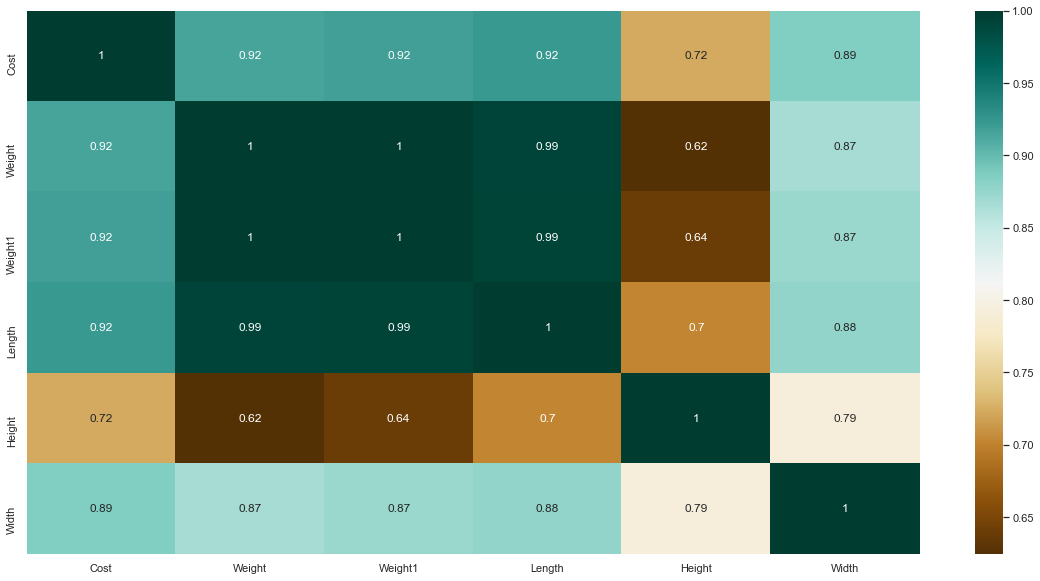

In [7]:
plt.figure(figsize=(20,10))
h = data.corr()
sns.heatmap(h,cmap="BrBG", annot=True)
data.drop(['Weight','Weight1'], axis=1, inplace=True)
print(data.shape)

Going to check for any outliers in the dependent and independent variables.

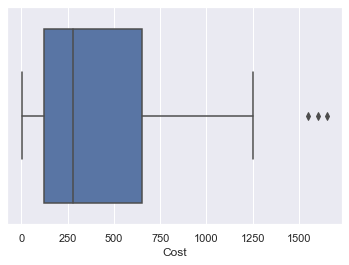

In [8]:
sns.boxplot(x=data['Cost'])

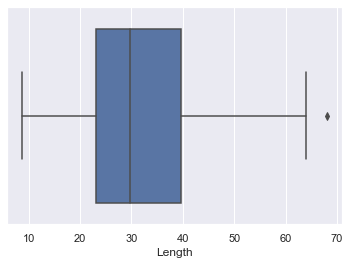

In [9]:
sns.boxplot(x=data['Length'])

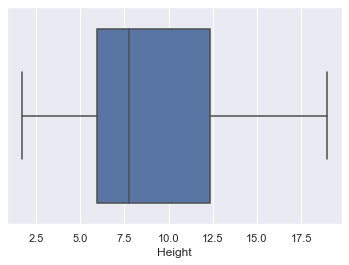

In [10]:
sns.boxplot(x=data['Height'])

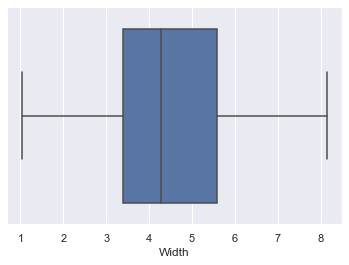

In [11]:
sns.boxplot(x=data['Width'])

Looks Cost and feature length have outlier value.

In [12]:
Q1 = data.quantile(0.25)
print(Q1)
Q3 = data.quantile(0.75)
print(Q3)
IQR = Q3 - Q1
print(IQR)
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print(data.shape)

Cost      121.25000
Length     23.20000
Height      5.94060
Width       3.39865
Name: 0.25, dtype: float64
Cost      650.00000
Length     39.67500
Height     12.37185
Width       5.58675
Name: 0.75, dtype: float64
Cost      528.75000
Length     16.47500
Height      6.43125
Width       2.18810
dtype: float64
(155, 4)


After removing the outliers

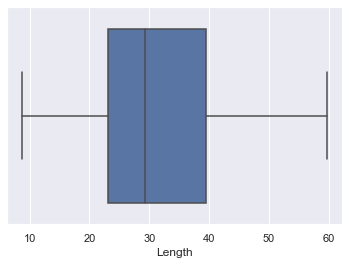

In [13]:
sns.boxplot(x=data['Length'])

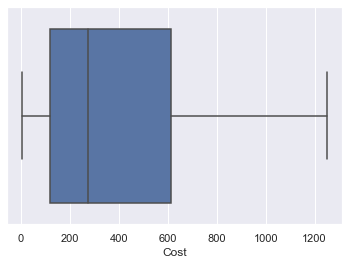

In [14]:
sns.boxplot(x=data['Cost'])

Drawing scatterplot to see the correlation between each independent variable to the dependent variable and make sure it doesn't look much scattered. Here all three looks fine.

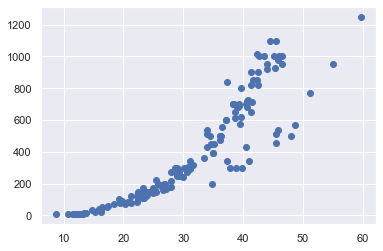

In [15]:
plt.scatter(data['Length'],data['Cost'])

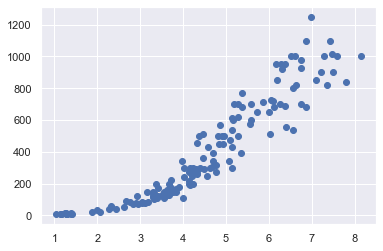

In [16]:
plt.scatter(data['Width'],data['Cost'])

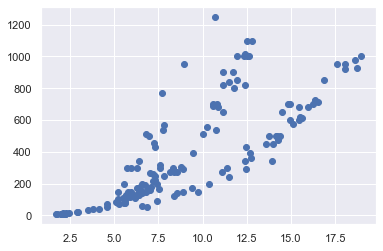

In [17]:
plt.scatter(data['Height'],data['Cost'])

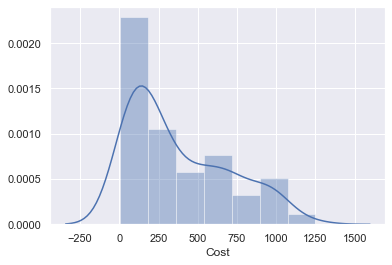

In [18]:
sns.distplot(data['Cost'])

Performing mean normalization to make all values between 0.0001 and 1 for efficient computations. Also applying log transformation to change the data into normal distribution format which will help to avoid predicting -ve cost. Because of log transformation normalized between 0.0001 to 1. I mean greater 0 to avoid errors while doing log transformation.

In [19]:
X= np.array(data.drop(['Cost'], 1))
y = np.array(data['Cost']).reshape(-1,1)
x_min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.00001,1))
y_min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.00001,1))
x_scaled = x_min_max_scaler.fit_transform(X)
y_scaled = y_min_max_scaler.fit_transform(y)
x_scaled = np.log(x_scaled)
y_scaled = np.log(y_scaled)

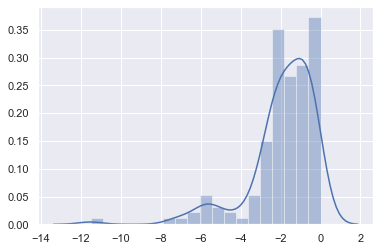

In [20]:
sns.distplot(y_scaled)

Splitting the dataset into training sample(80%), cross validatiion(10%) and testset(10%). Auto Shuffle the data each time to check for different possibility

In [21]:
X_train, X_rem , y_train, y_rem = sklearn.model_selection.train_test_split(x_scaled, y_scaled, test_size=0.2)
X_cv, X_test , y_cv, y_test = sklearn.model_selection.train_test_split(X_rem, y_rem, test_size=0.5)

In [22]:
def model_parameters(y_pred, y_cv):
    y_pred = np.exp(y_pred)
    y_cv = np.exp(y_cv)
    y_pred_inversed = y_min_max_scaler.inverse_transform(y_pred)
    y_cv_inversed = y_min_max_scaler.inverse_transform(y_cv)
    mse = mean_squared_error(y_cv_inversed,y_pred_inversed)
    rmse = math.sqrt(mse)
    r_squared = r2_score(y_cv_inversed,y_pred_inversed)
    print("R Squared value: {}".format(r_squared))
    print("RMSE value: {}".format(rmse))
    print("MSE value: {}".format(mse))
#     df = pd.DataFrame({'Actual': y_cv_inversed.flatten(), 'Predicted': y_pred_inversed.flatten()})
#     print(df)
    

In [23]:
def normal_sk_lib():
    reg.fit(X_train,y_train)
    print("Coefficient obtained is {}".format(reg.coef_))
    print("Intercept obtained is {}".format(reg.intercept_))
    model_parameters(reg.predict(X_cv), y_cv)


In [24]:
reg = LinearRegression()
normal_sk_lib()

Coefficient obtained is [[1.87098464 0.18158053 0.08823265]]
Intercept obtained is [0.34933979]
R Squared value: 0.9140338492195379
RMSE value: 92.71815738347853
MSE value: 8596.656708587494


In [25]:
y_pred = reg.predict(X_test)
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)
y_pred_inversed = y_min_max_scaler.inverse_transform(y_pred)
linear_prediction = y_pred_inversed
y_test_inversed = y_min_max_scaler.inverse_transform(y_test)
df = pd.DataFrame({'Actual': y_test_inversed.flatten(), 'Predicted': y_pred_inversed.flatten()})
print(df)

    Actual   Predicted
0     40.0   32.722182
1     70.0   56.865013
2    390.0  427.496725
3    456.0  733.460113
4     85.0   84.594008
5    900.0  735.883818
6    145.0  139.429827
7    685.0  587.880324
8   1000.0  777.226259
9    145.0  144.377529
10   110.0  122.210290
11   510.0  724.836082
12   475.0  503.448759
13   600.0  552.010021
14   290.0  260.945797
15   135.0  127.437837


------------------------------------------------------------------------

Common methods for Gradient descent Algorithms

In [26]:
def cost_function(X,y,theta):
    m = len(X)
    predictions = X.dot(theta)
    sqr_errors = np.power((np.subtract(predictions, y)), 2)
    cost = 1/(2*m) * sum(sqr_errors);
    return cost, predictions

In [27]:
def cross_validation_prediction(final_theta):
    cv_cost, y_pred = cost_function(X_cv, y_cv, final_theta)
    model_parameters(y_pred, y_cv)

In [28]:
def test_set_prediction(final_theta):
    y_pred = cost_function(X_test, y_test, final_theta)[1]
    y_pred = np.exp(y_pred)
    y_pred_inversed = y_min_max_scaler.inverse_transform(y_pred)
    y_test_inversed = y_min_max_scaler.inverse_transform(y_test)
    df = pd.DataFrame({'Actual': y_test_inversed.flatten(), 'Predicted': y_pred_inversed.flatten()})
    print(df)
    return y_pred_inversed

In [29]:
print(X_train.shape)
X_train = np.c_[np.ones((len(X_train), 1)), X_train]
print(X_train.shape)
X_cv = np.c_[np.ones((len(X_cv), 1)), X_cv]
print(X_cv.shape)
X_test = np.c_[np.ones((len(X_test), 1)), X_test]
print(X_test.shape)

(124, 3)
(124, 4)
(15, 4)
(16, 4)


Starting of Vanilla/Batch Gradient Descent Algorithm

In [30]:
def gradient_descent(theta):
    m = len(X_train)
    sqr_errors = [0] * len(theta)
    cost = [0] * len(theta)
    cost_history = [0] * iteration
    for i in range(0,iteration):
        predictions = X_train.dot(theta)
        for j in range(0,len(theta)):
            sqr_errors[j] = ((np.subtract(predictions, y_train)).T).dot(X_train[:,j])
            cost[j] = (1/m) * sqr_errors[j]
        for j in range(0,len(theta)):
            theta[j]=theta[j] - (alpha * cost[j]);
        cost_history[i] = cost_function(X_train,y_train,theta)[0]
    return theta, cost_history

In [31]:
iteration = 1000
alpha = 0.01
initial_theta = np.zeros((X_train.shape[1],1))
final_theta, cost_history = gradient_descent(initial_theta)
print("Intercept & Coefficients ",final_theta)
print("Final Cost value ",cost_history[-1])

Intercept & Coefficients  [[-0.01531263]
 [ 1.23572627]
 [ 0.2822524 ]
 [ 0.25638853]]
Final Cost value  [0.04800862]


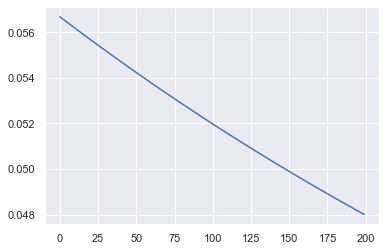

In [32]:
plt.plot(cost_history[-200:])
# plt.legend()

In [33]:
cross_validation_prediction(final_theta)

R Squared value: 0.8648368771914011
RMSE value: 116.25995757721067
MSE value: 13516.377735854825


In [34]:
vgd_prediction = test_set_prediction(final_theta)

    Actual   Predicted
0     40.0   45.557003
1     70.0   73.712604
2    390.0  384.705667
3    456.0  493.173067
4     85.0   99.771629
5    900.0  615.193787
6    145.0  151.037188
7    685.0  516.873774
8   1000.0  628.984816
9    145.0  157.243198
10   110.0  136.964428
11   510.0  486.559206
12   475.0  457.342184
13   600.0  503.837576
14   290.0  262.570231
15   135.0  140.764880


------------------------------------------------------------------------

Starting of Stochastic Gradient Descent Algorithm

In [35]:
def stochastic_gradient_descent(theta, iterations):
    m = len(X_train)
    sqr_errors = [0] * len(theta)
    cost = [0] * len(theta)
    cost_history = [0] * iterations
    for i in range(0,iterations):
        for s in range(0,m):
            predictions = X_train[s].dot(theta)
            for j in range(0,len(theta)):
                sqr_errors[j] = (predictions - y_train[s]) * X_train[s][j]
            for j in range(0,len(theta)):
                theta[j]=theta[j] - (alpha * sqr_errors[j]);
        cost_history[i] = cost_function(X_train,y_train,theta)[0]
    return theta, cost_history

In [36]:
iteration = 200
alpha = 0.01
initial_theta = np.zeros((X_train.shape[1],1))
final_theta, cost_history = stochastic_gradient_descent(initial_theta, iteration)
print("Intercept & Coefficients ",final_theta)
print("Final Cost value ",cost_history[-1])

Intercept & Coefficients  [[0.34236527]
 [1.95153626]
 [0.16750371]
 [0.07004693]]
Final Cost value  [0.02663984]


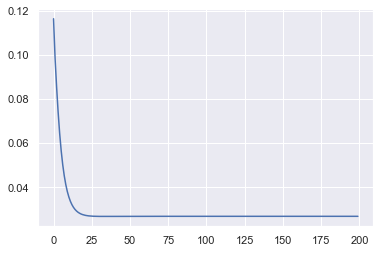

In [37]:
plt.plot(cost_history)

In [38]:
cross_validation_prediction(final_theta)

R Squared value: 0.9040458061004831
RMSE value: 97.9564487788799
MSE value: 9595.465857369321


In [39]:
sgd_prediction = test_set_prediction(final_theta)

    Actual   Predicted
0     40.0   30.044033
1     70.0   52.421196
2    390.0  410.900048
3    456.0  731.046865
4     85.0   78.729275
5    900.0  714.296047
6    145.0  131.012171
7    685.0  567.016333
8   1000.0  757.183534
9    145.0  135.519192
10   110.0  114.341307
11   510.0  722.781922
12   475.0  482.879777
13   600.0  529.228865
14   290.0  247.265904
15   135.0  119.465670


------------------------------------------------------------------------

Starting of Mini-Batch Gradient Descent Algorithm

In [40]:
def mini_batch_gradient_descent(theta, iterations):
    m = len(X_train)
    sqr_errors = [0] * len(theta)
    cost = [0] * len(theta)
    cost_history = [0] * iterations
    for i in range(0,iterations):
        for b in range(0,m,batch_size):
            predictions = X_train[b:b+batch_size].dot(theta)
            for j in range(0,len(theta)):
                sqr_errors[j] = ((np.subtract(predictions, y_train[b:b+batch_size])).T).dot(X_train[b:b+batch_size:,j])
                cost[j] = (1/len(X_train[b:b+batch_size])) * sqr_errors[j]
            for j in range(0,len(theta)):
                theta[j]=theta[j] - (alpha * cost[j]);
        cost_history[i] = cost_function(X_train,y_train,theta)[0]
    return theta, cost_history

In [41]:
batch_size = 10
iteration = 1000
alpha = 0.01
initial_theta = np.zeros((X_train.shape[1],1))
final_theta, cost_history = mini_batch_gradient_descent(initial_theta, iteration)
print("Intercept & Coefficients ",final_theta)
print("Final Cost value ",cost_history[-1])

Intercept & Coefficients  [[0.3631469 ]
 [1.90157353]
 [0.18983953]
 [0.0735991 ]]
Final Cost value  [0.02515958]


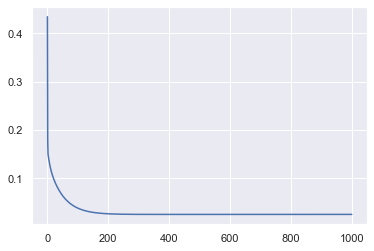

In [42]:
plt.plot(cost_history)

In [43]:
cross_validation_prediction(final_theta)

R Squared value: 0.9137052323197992
RMSE value: 92.89520201657122
MSE value: 8629.518557699577


In [44]:
mini_gd_prediction = test_set_prediction(final_theta)

    Actual   Predicted
0     40.0   31.682775
1     70.0   55.239512
2    390.0  425.060161
3    456.0  737.663639
4     85.0   82.638130
5    900.0  734.955462
6    145.0  136.840313
7    685.0  585.279875
8   1000.0  778.679031
9    145.0  141.951038
10   110.0  119.901537
11   510.0  728.047631
12   475.0  503.655501
13   600.0  552.353710
14   290.0  258.187606
15   135.0  124.965318


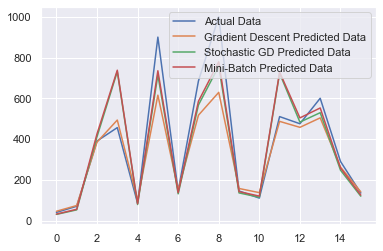

In [45]:
plt.plot(y_test_inversed,label="Actual Data")
plt.plot(vgd_prediction,label="Gradient Descent Predicted Data")
plt.plot(sgd_prediction,label="Stochastic GD Predicted Data")
plt.plot(mini_gd_prediction,label="Mini-Batch Predicted Data")
plt.legend()

Conclusion: The three features length, height and width are enough to predict the cost. All Coefficients are positive.
Instead of going with random iteration, We can do the RMSE calculation section inside the gradient calculation for cross validation data and choose the model with low RMSE and high R2 score.